# Prediction - European Calls

In [1]:
%run ../nn_option_pricer/_key_imports.py
import sys

sys.path.append("../")
from nn_option_pricer.bs import gbm_step, bs_eval_wrapper
from nn_option_pricer.nn_archi import make_model, homogeneity_network
from nn_option_pricer.utils import visualise_surface, diagnosis_hedge

In [3]:
# read in dataset
feat_names = ["log(S/K)", "ttm"]
f_to_i = lambda x: feat_names.index(x)

X_df = pd.read_csv("datasets/bs_train.csv")
Xs_train = X_df[feat_names].values
ys_train = X_df["call_true"]
true_grads_train = X_df["true_d_log(S/K)"]

X_df_test = pd.read_csv("datasets/bs_train.csv")
Xs_test = X_df[feat_names].values
ys_test = X_df_test["call_true"]

print("BASELINE MSE: ", np.mean((ys_test - ys_test.mean()) ** 2))
print("BASELINE MAE: ", np.mean(np.abs(ys_test - ys_test.mean())))
print(X_df.shape)

all_res = []

BASELINE MSE:  0.27744778604092013
BASELINE MAE:  0.3417168805512335
(65536, 12)


In [4]:
# from tensorflow.keras.layers import Dense, Input
# from tensorflow.keras import Model
# input_layer = Input(2)
# x = Dense(1, activation='exponential')(input_layer)
# output_layer = Dense(1, activation='softplus')(x)
# model = Model(input_layer, output_layer)
# model.layers[1].set_weights([np.array([1.0, 0.0]).reshape((-1, 1)), np.array([0.])])
# model.layers[2].set_weights([np.array([1.0]).reshape((-1, 1)), np.array([-1.0])])
# model(Xs_train)

In [5]:
# sns.scatterplot(X_df['log(S/K)'],)
# sns.scatterplot(X_df['log(S/K)'],  X_df['call_true'] - , label="Softmax Approx")

In [6]:
"""
Neural Network Hyperparameters
"""
HIDDEN_UNITS = 32
LAYERS = 2
dropout_ratio = 0.0
HIDDEN_ACT = "softplus"
N_FEATS = 2
OUTPUT_ACT = "softplus"
DROPOUT_RATIO = 0.0
LR = 1e-3
BATCH_SIZE = 256
EPOCHS = 30
BATCH_NORM = True
loss_fn = tf.keras.losses.MeanSquaredError()
METRICS = [
    tf.keras.metrics.MeanAbsoluteError(name="MAE"),
    tf.keras.metrics.RootMeanSquaredError(name="RMSE"),
]
VAL_SPLIT = 0.2

In [7]:
moneyness = np.exp(Xs_test[:, f_to_i("log(S/K)")])
ttm = np.exp(Xs_test[:, f_to_i("ttm")])
true = X_df_test["call_true"]
intrinsic_val = np.maximum(moneyness - 1.0, 0)
all_model_preds = {}
all_model_grads = {}
all_model_hessian = {}
all_models = {}

# Feed-Forward Neural Network

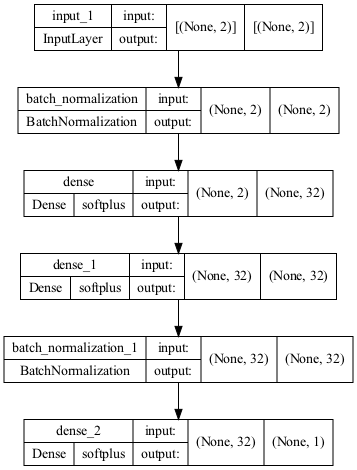

In [8]:
"""
Define Neural Network
"""
CALLBACKS = [
    EarlyStopping(patience=10, restore_best_weights=True),
    TQDMProgressBar(show_epoch_progress=False),
    ReduceLROnPlateau(patience=5),
]
opt = Adam(learning_rate=LR)
METHOD = "standard_ffn"

all_models[METHOD] = make_model(
    N_FEATS, HIDDEN_UNITS, LAYERS, DROPOUT_RATIO, HIDDEN_ACT, OUTPUT_ACT, BATCH_NORM
)
all_models[METHOD].compile(optimizer=opt, loss=loss_fn, metrics=METRICS)
tf.keras.utils.plot_model(
    all_models[METHOD], show_layer_activations=True, show_shapes=True, dpi=72
)

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

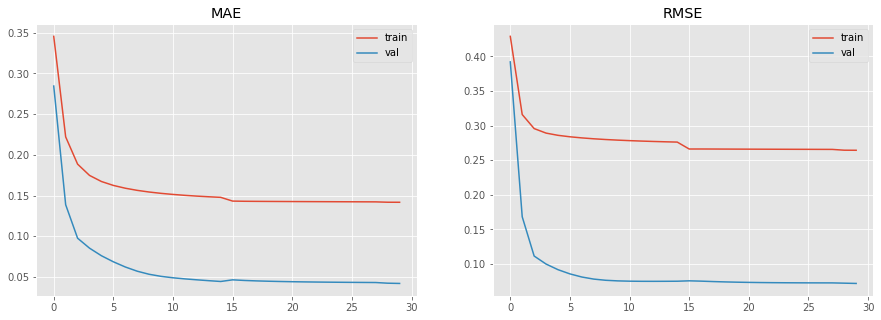

In [9]:
"""
Training
"""
start = time.time()
history = all_models[METHOD].fit(
    Xs_train,
    ys_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    shuffle=False,
    verbose=0,
    callbacks=CALLBACKS,
)
train_time = time.time() - start

metrics = ["MAE", "RMSE"]
fig, ax = plt.subplots(figsize=(15, 5), ncols=2)
for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric], label="train")
    ax[i].plot(history.history[f"val_{metric}"], label="val")
    ax[i].legend()
    ax[i].set_title(metric)

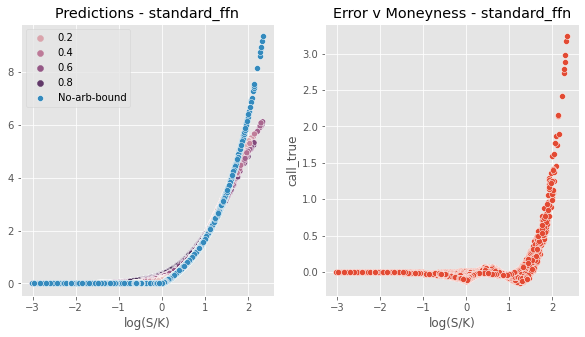

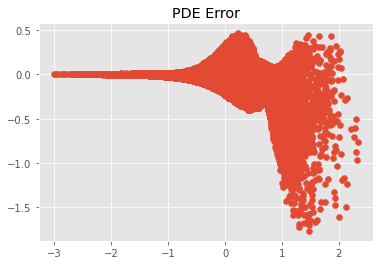

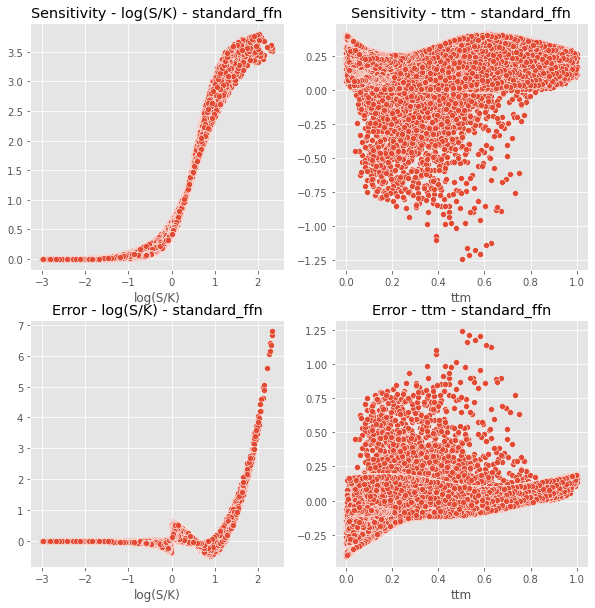

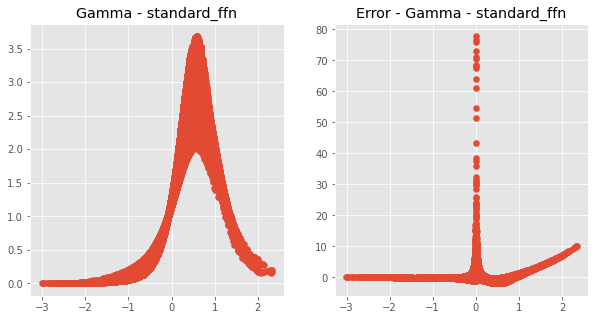

In [10]:
"""
Prediction Errors
"""
start2 = time.time()
all_model_preds[METHOD] = (
    all_models[METHOD].predict(Xs_test, batch_size=10**4).reshape(-1)
)

"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs_test)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = all_models[METHOD](X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log(S/K)")], X_tensor)
all_model_grads[METHOD] = grads.numpy()
all_model_hessian[METHOD] = hessian1.numpy()[:, [0]]
inference_time = time.time() - start2


temp = bs_eval_wrapper(
    X_df_test,
    true_val=true,
    preds=all_model_preds[METHOD],
    grads=all_model_grads[METHOD],
    hessian_moneyness=all_model_hessian[METHOD],
    lower_bound=intrinsic_val,
    upper_bound=None,
    METHOD=METHOD,
)

temp["model_parameters"] = all_models[METHOD].count_params()
temp["train_time"] = train_time
temp["inference_time"] = inference_time

all_res += [temp.copy()]

In [11]:
temp.T

,standard_ffn
pred_l1,0.040631
pred_l2,0.067363
pred_l_inf,3.236352
pred_lower_bound_violation,0.119751
PDE_mean,-0.031294
PDE_l1,0.096505
PDE_l2,0.152050
PDE_l_inf,1.768546
monotonicity_error,0.000000
time_value_error,0.028305


<Axes3DSubplot:title={'center':'Surface'}, xlabel='Moneyness', ylabel='ttm'>

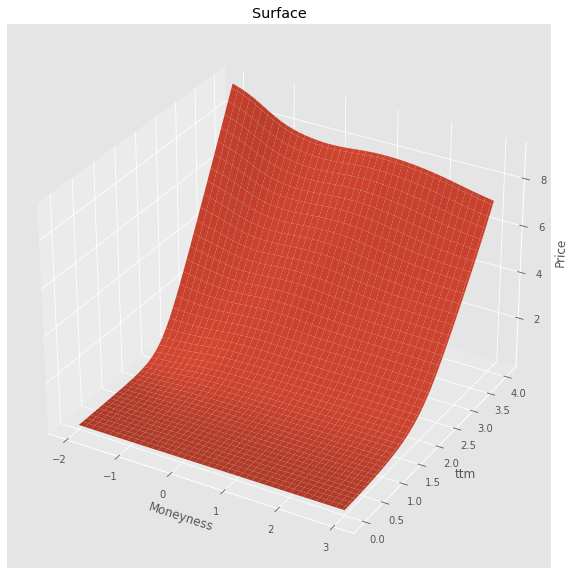

In [12]:
"""
Visualise call surface
"""
SK = np.linspace(-2, 3, 128)
ts = np.linspace(0, 4, 128)
X = np.array(list(product(SK, ts)))
visualise_surface(SK, ts, all_models[METHOD](X).numpy())

# NN with a homogeneity hint

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

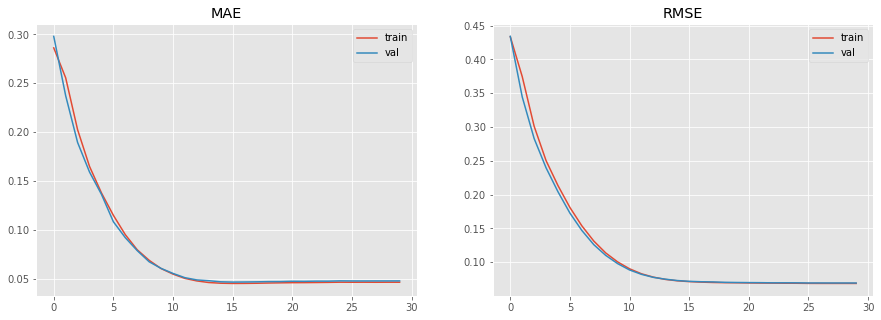

In [14]:
"""
Define Neural network
"""
CALLBACKS = [
    EarlyStopping(patience=10, restore_best_weights=True),
    TQDMProgressBar(show_epoch_progress=False),
    ReduceLROnPlateau(patience=5),
]
opt = Adam(learning_rate=LR)

METHOD = "gated"
all_models[METHOD] = homogeneity_network(N_FEATS, HIDDEN_UNITS, seed=42)
all_models[METHOD].compile(optimizer=opt, loss=loss_fn, metrics=METRICS)
start = time.time()
history = all_models[METHOD].fit(
    [Xs_train[:, 0], Xs_train[:, 1]],
    ys_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    verbose=0,
    shuffle=True,
    callbacks=CALLBACKS,
)
train_time = time.time() - start
metrics = ["MAE", "RMSE"]
fig, ax = plt.subplots(figsize=(15, 5), ncols=2)
for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric], label="train")
    ax[i].plot(history.history[f"val_{metric}"], label="val")
    ax[i].legend()
    ax[i].set_title(metric)

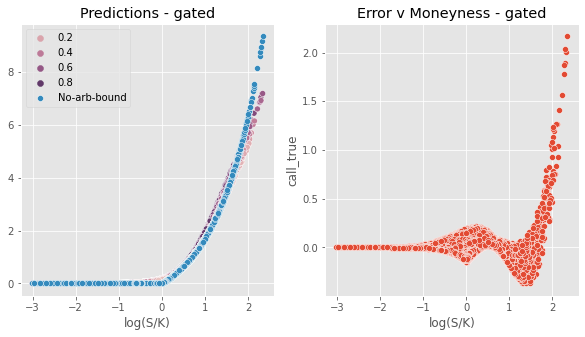

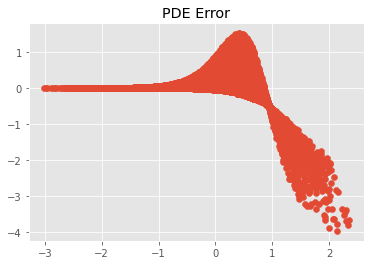

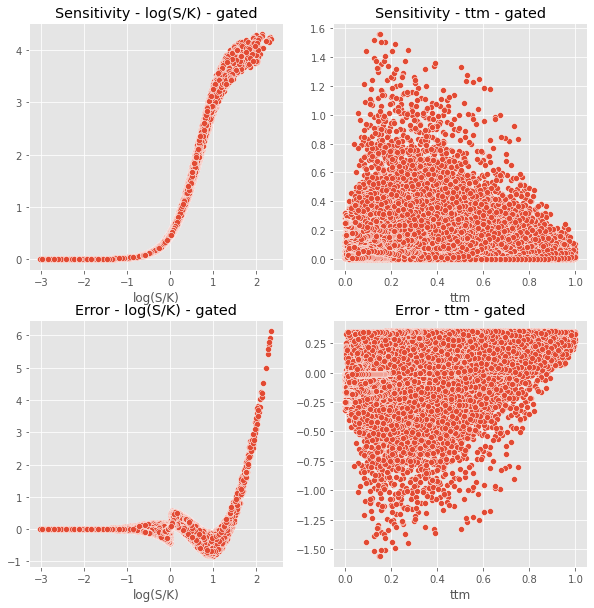

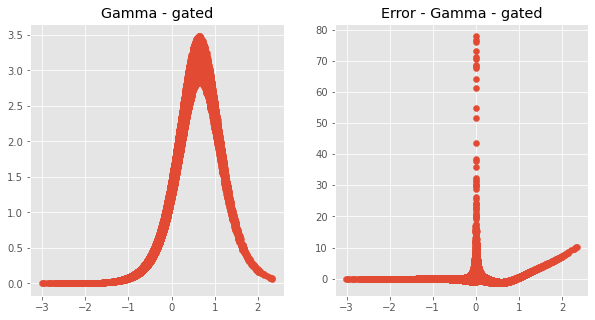

In [15]:
all_model_preds["gated"] = (
    all_models["gated"]
    .predict([Xs_train[:, 0], Xs_train[:, 1]], batch_size=10**4)
    .reshape(-1)
).reshape(-1)

"""
Compute all Gradients, Hessian
"""
start2 = time.time()
X_tensor = tf.Variable(Xs_test)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = all_models["gated"]([X_tensor[:, 0], X_tensor[:, 1]])
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log(S/K)")], X_tensor)
inference_time = time.time() - start2

all_model_grads[METHOD] = grads.numpy()
all_model_hessian[METHOD] = hessian1.numpy()[:, [0]]

temp = bs_eval_wrapper(
    X_df_test,
    true_val=true,
    preds=all_model_preds[METHOD],
    grads=all_model_grads[METHOD],
    hessian_moneyness=all_model_hessian[METHOD],
    lower_bound=intrinsic_val,
    upper_bound=None,
    METHOD=METHOD,
)

temp["model_parameters"] = all_models[METHOD].count_params()
temp["train_time"] = train_time
temp["inference_time"] = inference_time

all_res += [temp.copy()]

<Axes3DSubplot:title={'center':'Surface'}, xlabel='Moneyness', ylabel='ttm'>

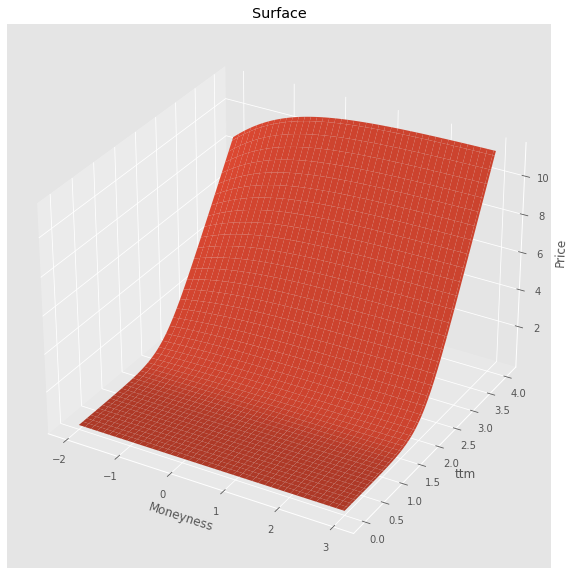

In [16]:
"""
Visualise call surface
"""
SK = np.linspace(-2, 3, 128)
ts = np.linspace(0, 4, 128)
X = np.array(list(product(SK, ts)))
visualise_surface(SK, ts, all_models["gated"]([X[:, 0], X[:, 1]]).numpy())

# Differential NN

  0%|          | 0/30 [00:00<?, ?it/s]

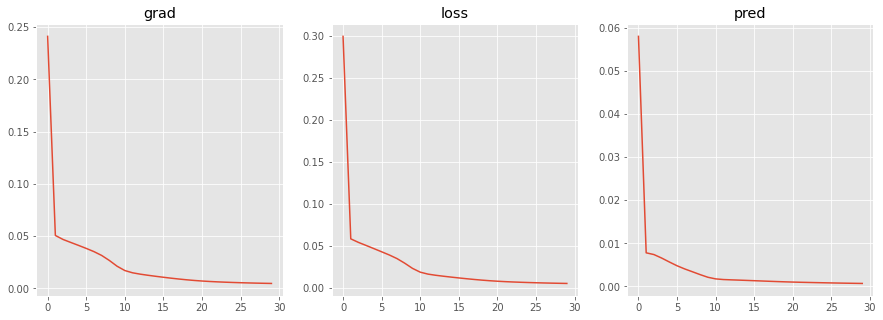

In [18]:
"""
Define Neural Network
"""
dataset = tf.data.Dataset.from_tensor_slices((Xs_train, ys_train, true_grads_train))
opt = Adam(learning_rate=LR)
model = make_model(
    N_FEATS, HIDDEN_UNITS, LAYERS, DROPOUT_RATIO, HIDDEN_ACT, OUTPUT_ACT, BATCH_NORM
)

batched_dataset = dataset.batch(BATCH_SIZE)
METHOD = "differential"


@tf.function
def train(y, true_grad, x_var):
    with tf.GradientTape() as model_tape:
        with tf.GradientTape() as grad_tape:
            output = model(x_var)
        gradients = grad_tape.gradient(output, x_var)
        grad_loss = tf.keras.losses.MeanSquaredError()(true_grad, gradients[:, 0])
        pred_loss = tf.keras.losses.MeanSquaredError()(output, y)
        loss = grad_loss + pred_loss
        model_grad = model_tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(model_grad, model.trainable_variables))
    return loss, pred_loss, grad_loss


losses = {
    "grad": [None for i in range(EPOCHS)],
    "loss": [None for i in range(EPOCHS)],
    "pred": [None for i in range(EPOCHS)],
}
start = time.time()
for epoch in tqdm(range(EPOCHS)):
    temp_pred = []
    temp_grad = []
    temp_loss = []
    for step, (x, y_true, true_grad) in enumerate(batched_dataset):
        x_var = tf.Variable(x)
        loss, pred_loss, grad_loss = train(y_true, true_grad, x_var)
        temp_pred += [pred_loss.numpy()]
        temp_grad += [grad_loss.numpy()]
        temp_loss += [loss.numpy()]
    losses["grad"][epoch] = [np.mean(temp_grad)]
    losses["pred"][epoch] = [np.mean(temp_pred)]
    losses["loss"][epoch] = [np.mean(temp_loss)]
train_time = time.time() - start

all_models[METHOD] = model
fig, ax = plt.subplots(figsize=(15, 5), ncols=3)
for i, metric in enumerate(losses.keys()):
    ax[i].plot(losses[metric])
    ax[i].set_title(metric)

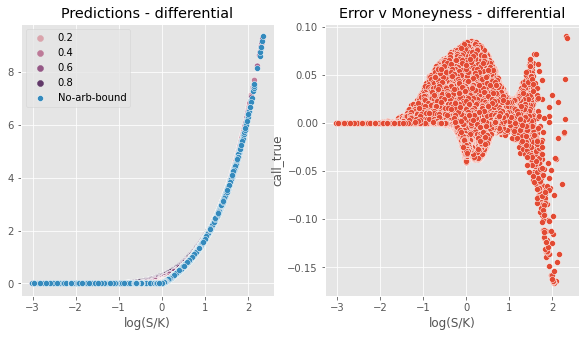

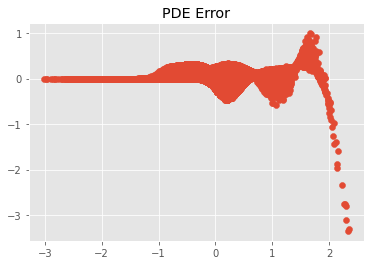

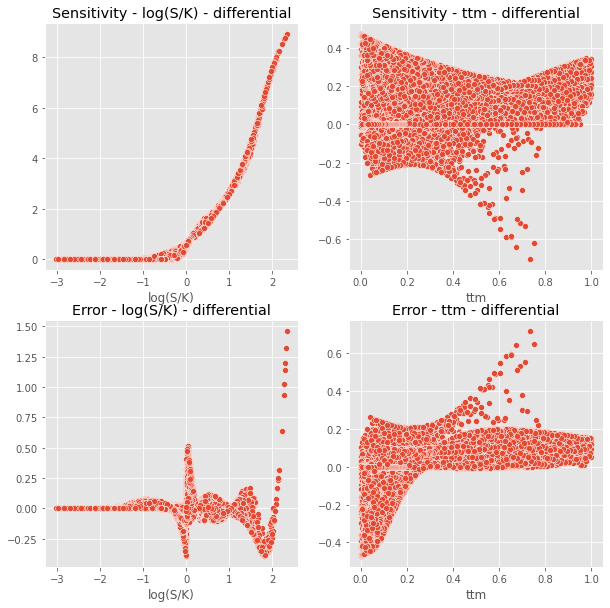

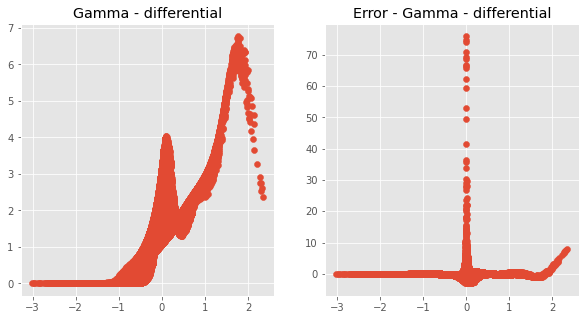

In [19]:
"""
Prediction Errors
"""
start2 = time.time()
all_model_preds[METHOD] = (
    all_models[METHOD].predict(Xs_test, batch_size=10**4).reshape(-1)
)

"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs_test)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = all_models[METHOD](X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log(S/K)")], X_tensor)
inference_time = time.time() - start2

all_model_grads[METHOD] = grads.numpy()
all_model_hessian[METHOD] = hessian1.numpy()[:, [0]]

temp = bs_eval_wrapper(
    X_df_test,
    true_val=true,
    preds=all_model_preds[METHOD],
    grads=all_model_grads[METHOD],
    hessian_moneyness=all_model_hessian[METHOD],
    lower_bound=intrinsic_val,
    upper_bound=None,
    METHOD=METHOD,
)

temp["model_parameters"] = all_models[METHOD].count_params()
temp["train_time"] = train_time
temp["inference_time"] = inference_time

all_res += [temp.copy()]

# Neural PDE

  0%|          | 0/30 [00:00<?, ?it/s]

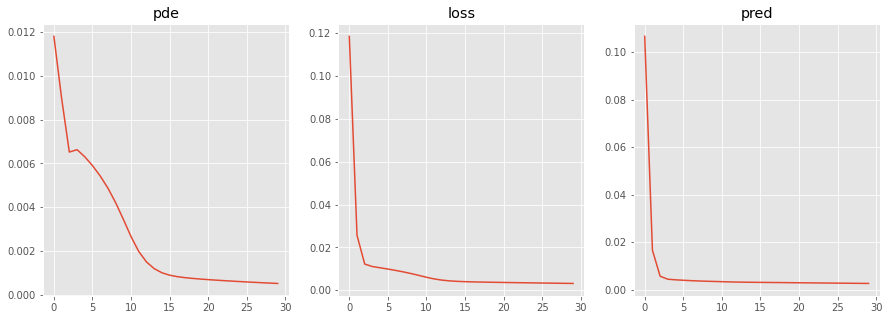

In [20]:
"""
Define Neural Network
"""
opt = Adam(learning_rate=LR)
METHOD = "ffn+pde"
model = make_model(
    N_FEATS, HIDDEN_UNITS, LAYERS, DROPOUT_RATIO, HIDDEN_ACT, OUTPUT_ACT, BATCH_NORM
)
dataset = tf.data.Dataset.from_tensor_slices((Xs_train, ys_train))
batched_dataset = dataset.batch(BATCH_SIZE)


@tf.function
def train(y, x_var):
    with tf.GradientTape() as model_tape:
        with tf.GradientTape() as hessian_tape:
            with tf.GradientTape() as grad_tape:
                output = model(x_var)
            gradients = grad_tape.gradient(output, x_var)
            hessian = hessian_tape.gradient(gradients[:, 0], x_var)
            pde_loss = tf.math.reduce_mean(
                (gradients[:, 1] + x_var[:, 1] * (-hessian[:, 0] + gradients[:, 0]))
                ** 2
            )
            pred_loss = tf.keras.losses.MeanSquaredError()(output, y)
            loss = pde_loss + pred_loss
            model_grad = model_tape.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(model_grad, model.trainable_variables))
    return loss, pred_loss, pde_loss


losses = {"pde": [], "loss": [], "pred": []}
start = time.time()
for epoch in tqdm(range(EPOCHS)):
    temp_pred = []
    temp_pde = []
    temp_loss = []
    for step, (x, y_true) in enumerate(batched_dataset):
        x_var = tf.Variable(x)
        loss, pred_loss, pde_loss = train(y_true, x_var)
        temp_pred += [pred_loss.numpy()]
        temp_pde += [pde_loss.numpy()]
        temp_loss += [loss.numpy()]
    losses["pde"] += [np.mean(temp_pde)]
    losses["pred"] += [np.mean(temp_pred)]
    losses["loss"] += [np.mean(temp_loss)]
train_time = time.time() - start

all_models[METHOD] = model
fig, ax = plt.subplots(figsize=(15, 5), ncols=3)
for i, metric in enumerate(losses.keys()):
    ax[i].plot(losses[metric])
    ax[i].set_title(metric)

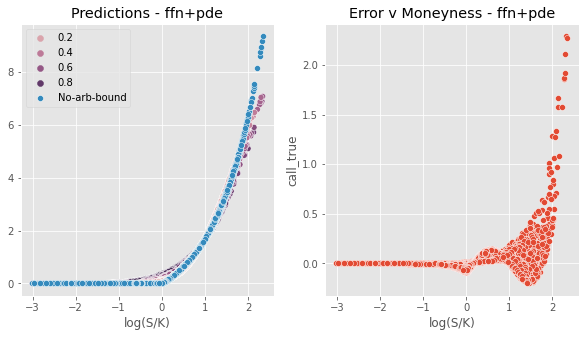

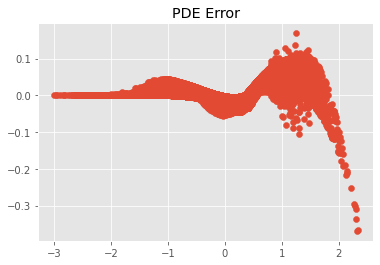

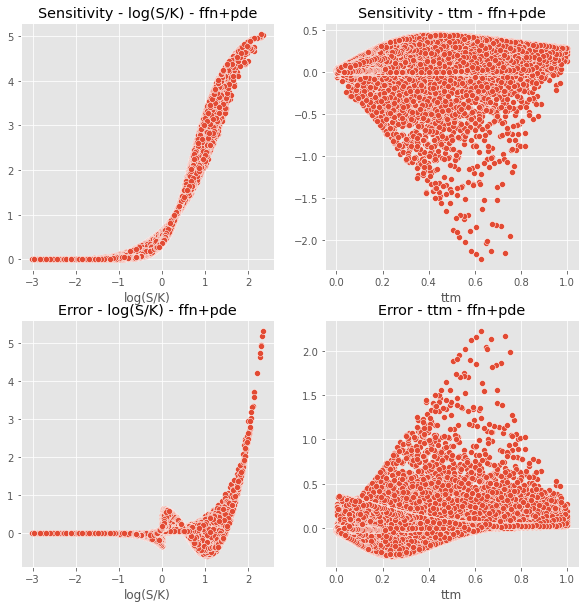

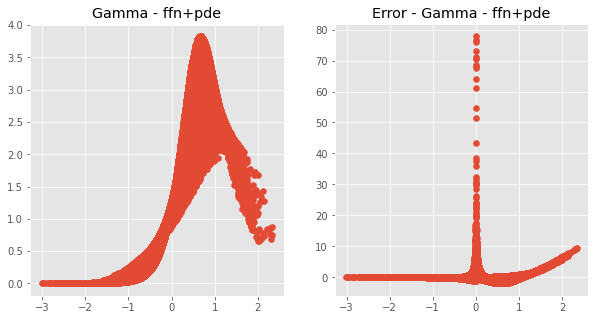

In [21]:
"""
Prediction Errors
"""
start2 = time.time()
all_model_preds[METHOD] = (
    all_models[METHOD].predict(Xs_test, batch_size=10**4).reshape(-1)
)

"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs_test)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = all_models[METHOD](X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log(S/K)")], X_tensor)
inference_time = time.time() - start2

all_model_grads[METHOD] = grads.numpy()
all_model_hessian[METHOD] = hessian1.numpy()[:, [0]]

temp = bs_eval_wrapper(
    X_df_test,
    true_val=true,
    preds=all_model_preds[METHOD],
    grads=all_model_grads[METHOD],
    hessian_moneyness=all_model_hessian[METHOD],
    lower_bound=intrinsic_val,
    upper_bound=None,
    METHOD=METHOD,
)

temp["model_parameters"] = all_models[METHOD].count_params()
temp["train_time"] = train_time
temp["inference_time"] = inference_time

all_res += [temp.copy()]

<AxesSubplot:xlabel='log(S/K)', ylabel='true_d2_log(S/K)'>

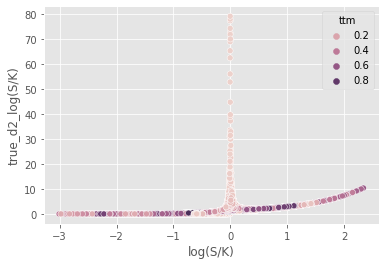

In [22]:
sns.scatterplot(X_df["log(S/K)"], X_df["true_d2_log(S/K)"], hue=X_df["ttm"])

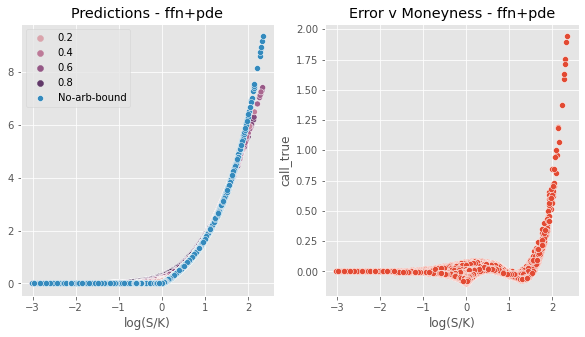

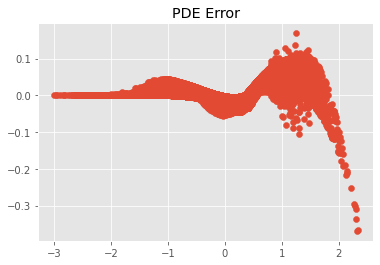

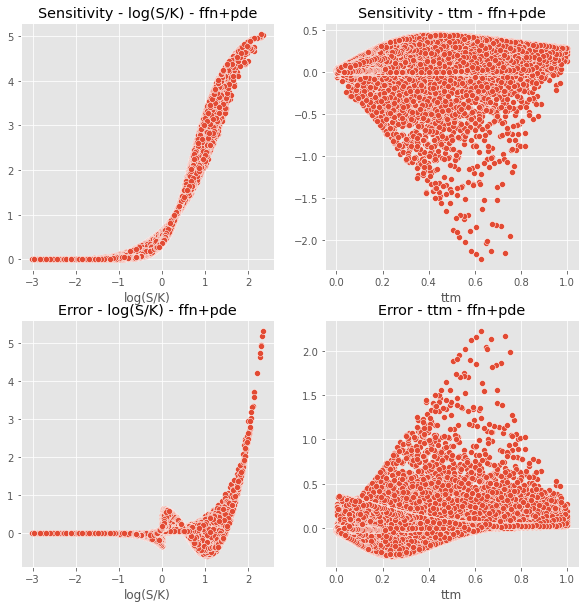

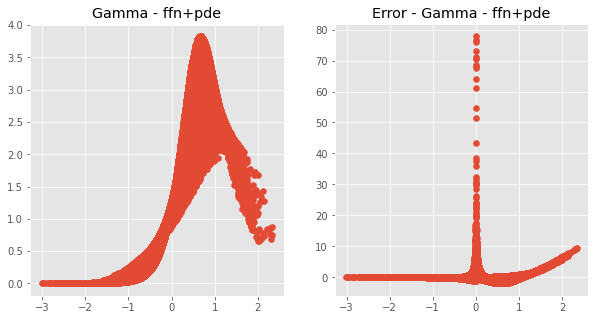

In [23]:
ensemble_preds = pd.DataFrame(all_model_preds).mean(axis=1).values


temp = bs_eval_wrapper(
    X_df_test,
    true_val=true,
    preds=ensemble_preds,
    grads=all_model_grads[METHOD],
    hessian_moneyness=all_model_hessian[METHOD],
    lower_bound=intrinsic_val,
    upper_bound=None,
    METHOD=METHOD,
)

temp["model_parameters"] = all_models[METHOD].count_params()
temp["train_time"] = train_time
temp["inference_time"] = inference_time

all_res += [temp.copy()]

In [24]:
all_res_df = (
    pd.concat(all_res)
    .reset_index()
    .drop_duplicates(subset=["index"], keep="last")
    .set_index("index")
    .T
)
print(all_res_df.to_latex())
display(all_res_df.style.background_gradient(axis=1))

\begin{tabular}{lrrrr}
\toprule
index &  standard\_ffn &       gated &  differential &      ffn+pde \\
\midrule
pred\_l1                    &      0.040631 &    0.046740 &      0.015507 &     0.026920 \\
pred\_l2                    &      0.067363 &    0.068782 &      0.022049 &     0.041887 \\
pred\_l\_inf                 &      3.236352 &    2.166205 &      0.166790 &     1.941423 \\
pred\_lower\_bound\_violation &      0.119751 &    0.124237 &      0.070984 &     0.149490 \\
PDE\_mean                   &     -0.031294 &    0.123594 &      0.032445 &     0.001583 \\
PDE\_l1                     &      0.096505 &    0.226466 &      0.109551 &     0.014434 \\
PDE\_l2                     &      0.152050 &    0.390584 &      0.152133 &     0.021305 \\
PDE\_l\_inf                  &      1.768546 &    3.974675 &      3.349788 &     0.368886 \\
monotonicity\_error         &      0.000000 &    0.000000 &      0.000000 &     0.000000 \\
time\_value\_error           &      0.028305 &    0.0000

index,standard_ffn,gated,differential,ffn+pde
pred_l1,0.040631,0.046740,0.015507,0.026920
pred_l2,0.067363,0.068782,0.022049,0.041887
pred_l_inf,3.236352,2.166205,0.166790,1.941423
pred_lower_bound_violation,0.119751,0.124237,0.070984,0.149490
PDE_mean,-0.031294,0.123594,0.032445,0.001583
PDE_l1,0.096505,0.226466,0.109551,0.014434
PDE_l2,0.152050,0.390584,0.152133,0.021305
PDE_l_inf,1.768546,3.974675,3.349788,0.368886
monotonicity_error,0.000000,0.000000,0.000000,0.000000
time_value_error,0.028305,0.000000,0.045883,0.032684


<AxesSubplot:>

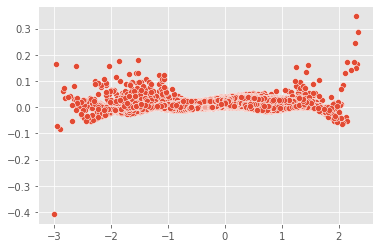

In [25]:
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression

start = time.time()
spline = SplineTransformer(
    n_knots=12, degree=3, knots="uniform", extrapolation="linear"
)
spline = PolynomialFeatures(degree=10)
X2 = spline.fit_transform(Xs_train)
reg = LinearRegression(fit_intercept=True).fit(X2, X_df["call_true"])
training_time = time.time()

start2 = time.time()
grads = np.zeros((Xs_train.shape[0], 2))
eps = 1e-3
hessian = np.zeros((Xs_train.shape[0], 1))
X_upper = Xs_train.copy()
X_upper[:, 0] += eps
X2_upper = spline.fit_transform(X_upper)
X_lower = Xs_train.copy()
X_lower[:, 0] -= eps
X2_lower = spline.fit_transform(X_lower)
grads[:, 0] = (reg.predict(X2_upper) - reg.predict(X2_lower)) / (2 * eps)
hessian[:, 0] = (
    reg.predict(X2_upper) - 2 * reg.predict(X2) + reg.predict(X2_lower)
) / (eps * eps)
X_upper2 = Xs_train.copy()
X_upper2[:, 1] += 1e-4
X2_upper2 = spline.fit_transform(X_upper2)
grads[:, 1] = (reg.predict(X2_upper2) - reg.predict(X2)) / eps
inference_time = time.time() - start2

sns.scatterplot(Xs_train[:, 0], grads[:, 1])

# sns.scatterplot(x = Xs_train[:, f_to_i("log(S/K)")],
#                 y = reg.predict(X2),
#                 hue = Xs_train[:, f_to_i("ttm")])

In [ ]:
# preds = model.predict(Xs).reshape(-1)
# X_tensor = tf.Variable(Xs)
# with tf.GradientTape() as tape:
#     output = model(X_tensor)
#     grads = tape.gradient(output, X_tensor)

# delta = grads[:,0].numpy().reshape((-1, 32))
# St = X_df['log(S/K)'].values.reshape((2048, -1))
# payoff = X_df.groupby('path')['call_payoff'].mean().values
# hedge_pnl = preds[::32] + np.sum(delta[:, :-1] * np.diff(St, axis = 1), axis = 1) - payoff

# sns.histplot(hedge_pnl)

# Polynomial Basis